In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import notebook_helper
import sys
import numpy as np
import imodelsx
import imodelsx.process_results
import mprompt.data.data
from mprompt.data.data import TASKS_D3
# import mprompt.methods.m4_evaluate as m4_evaluate
import warnings
import scipy.stats
def sem(x):
    '''Compute standard error of the mean, ignoring NaNs
    '''
    with warnings.catch_warnings():
        return scipy.stats.sem(x, ddof=0)
tqdm.pandas()
TASK_NAMES = list(TASKS_D3.keys())
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/mprompt/feb18_synthetic_sweep'
results_dir = '/home/chansingh/mntv1/mprompt/feb25'

In [ ]:
# r = pd.read_pickle('../results/results_synthetic.pkl')
r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename='01_explain.py')
r = notebook_helper.process_and_add_scores(r, add_bert_scores=True)
r.to_pickle('../results/results_synthetic.pkl')

In [ ]:
# simplifying
default_params = {
    'noise_ngram_scores': 0,
    'module_num_restrict': -1,
}
rd = r
for k, v in default_params.items():
    rd = rd[rd[k] == v]

# Top results

### Explanation recovery accuracy results

In [ ]:
def round_3(x):
    return x.apply(lambda x: f'{x:.3f}')
def round_2(x):
    return x.apply(lambda x: f'{x:.2f}')

In [ ]:
groupings = ['noise_ngram_scores', 'ngrams_restricted']
metrics = ['any_contains_keywords', 'top_contains_keywords', 'mean_contains_keywords']
metrics_weighted = ['mean_contains_keywords_weighted']
if 'score_bert' in r.columns:
    metrics += ['any_bert', 'top_bert', 'mean_bert']
    metrics_weighted += ['mean_bert_weighted']
helpers = ['row_count_helper', 'num_generated_explanations']
index_remap = {
    (0.0, False): 'Default',
    (0.0,  True): 'Restricted ngrams',
    (3.0, False): 'Noisy module',
}

g = (
    r
    .filter(groupings + metrics + metrics_weighted + helpers)
    .groupby(groupings)
    .aggregate(['sum', sem], numeric_only=True)
)
g.columns = [x[0]+'_err' if x[1] == 'sem' else x[0] for x in g.columns]

for met in metrics:
    g[met] = g[met] / g['row_count_helper']
for met in metrics_weighted:
    g[met] = g[met] / g['num_generated_explanations']

g.index = [index_remap[x] for x in g.index.values]
columns=[k for k in g.columns if not k.endswith('_err')]
for col in columns:
    err = g[col + '_err']
    if col == 'mean_contains_keywords_weighted':
        err = g['mean_contains_keywords_err']
        err *= np.sqrt(g['row_count_helper'] / g['num_generated_explanations'])
    g[col] = round_3(g[col]) + ' \\err{' + round_2(err) + '}'

g = g.drop(columns=helpers + 
           [k for k in ['mean_contains_keywords', 'mean_bert', 'any_bert', 'any_contains_keywords'] if k in g.columns])

g = g.rename(
    columns={
            'any_contains_keywords': 'Accuracy (top-5)',
            'top_contains_keywords': 'Accuracy',
            'mean_contains_keywords_weighted': '\\makecell{Accuracy\\\\(no ranking)}',
            'mean_contains_keywords': 'Accuracy (no ranking, unweighted)',
            'top_bert': 'BERT Score',
            'mean_bert_weighted': '\\makecell{BERT Score\\\\(no ranking)}',
        }
)
cols_print = [k for k in g.columns if not k.endswith('_err')]
display(g[cols_print])
print(g[cols_print].style.to_latex(hrules=True).replace('lllll', 'lcccc'))

### Does synthetic score help explanation recovery?

In [ ]:
groupings = ['noise_ngram_scores', 'ngrams_restricted', 'top_contains_keywords']
metrics = ['top_score_synthetic']
g2 = (
    r
    .filter(groupings + metrics)
    .groupby(groupings)
    .mean()
    .round(3)
    .pivot_table(index=['noise_ngram_scores', 'ngrams_restricted'],
                 columns='top_contains_keywords',
                 values='top_score_synthetic')
    .rename_axis(None, axis=1)  
    .rename(columns={
    True: 'Synthetic score (correct)',
    False: 'Synthetic score (incorrect)',
    })
)
g2.index = [index_remap[x] for x in g2.index.values]
display(g2)

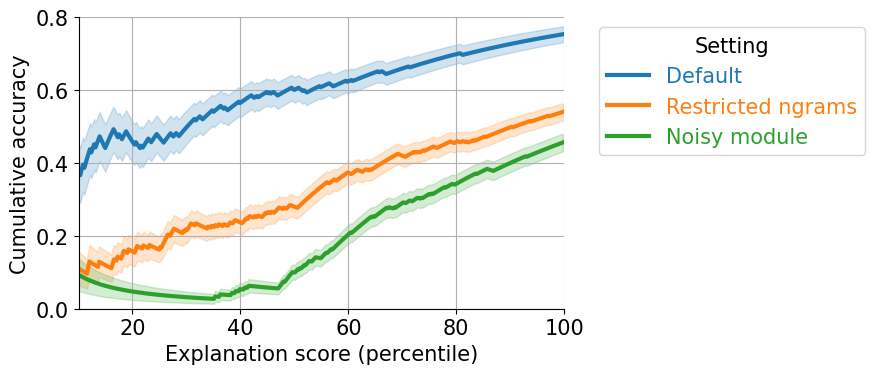

In [15]:
r['task_variation'] = r.apply(lambda row: index_remap[(row.noise_ngram_scores, row.ngrams_restricted)], axis=1)
# COLORS = ['black', 'C0', 'C1']
COLORS = ['C0', 'C1', 'C2']
plt.figure(figsize=(9, 4))
# for i, task_variation in enumerate(sorted(r.task_variation.unique())):
for i, task_variation in enumerate(['Default', 'Restricted ngrams', 'Noisy module']):
    d = r[r.task_variation == task_variation]


    # compute corrects
    scores_synth = sum(d.score_synthetic.values, [])
    corrects = sum(d.score_contains_keywords.values, [])
    args = np.argsort(scores_synth)
    scores_synth = np.array(scores_synth)[args]
    corrects = np.array(corrects)[args]

    # plot
    cum = np.arange(1, len(corrects) + 1)
    cumsums = np.cumsum(corrects) / cum
    sems = np.sqrt(cumsums * (1 - cumsums) / cum)

    # only plot >= 0
    args2 = scores_synth >= -1000
    s = scores_synth[args2]
    c = cumsums[args2]
    sems = sems[args2]

    x = s
    x = np.arange(len(s)) / len(s) * 100
    plt.plot(x, c, '-', label=task_variation, lw=3, color=COLORS[i])
    plt.fill_between(x, c - sems, c + sems, alpha=0.2, interpolate=True, color=COLORS[i])
    plt.ylabel('Cumulative accuracy')
    plt.xlabel('Explanation score (percentile)')
    plt.grid()
    # plt.show()

plt.legend(labelcolor='linecolor', bbox_to_anchor=(1.05, 1), loc='upper left', title='Setting')
plt.xlim(10, 100)
plt.ylim(0.0, 0.8)
# dvu.line_legend()
plt.savefig('../results/synthetic/explanation_score_curves.pdf', bbox_inches='tight')
plt.show()